# BSPF Event Analysis - Dispersion

With pressure sensor parascientific and new sensor 

In [7]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [8]:
from functions.request_data import __request_data

In [9]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)

## Configurations

In [10]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

config['fmin'], config['fmax'] = 1.0, 17

## Load Data

In [11]:
# from functions.request_data import __request_data

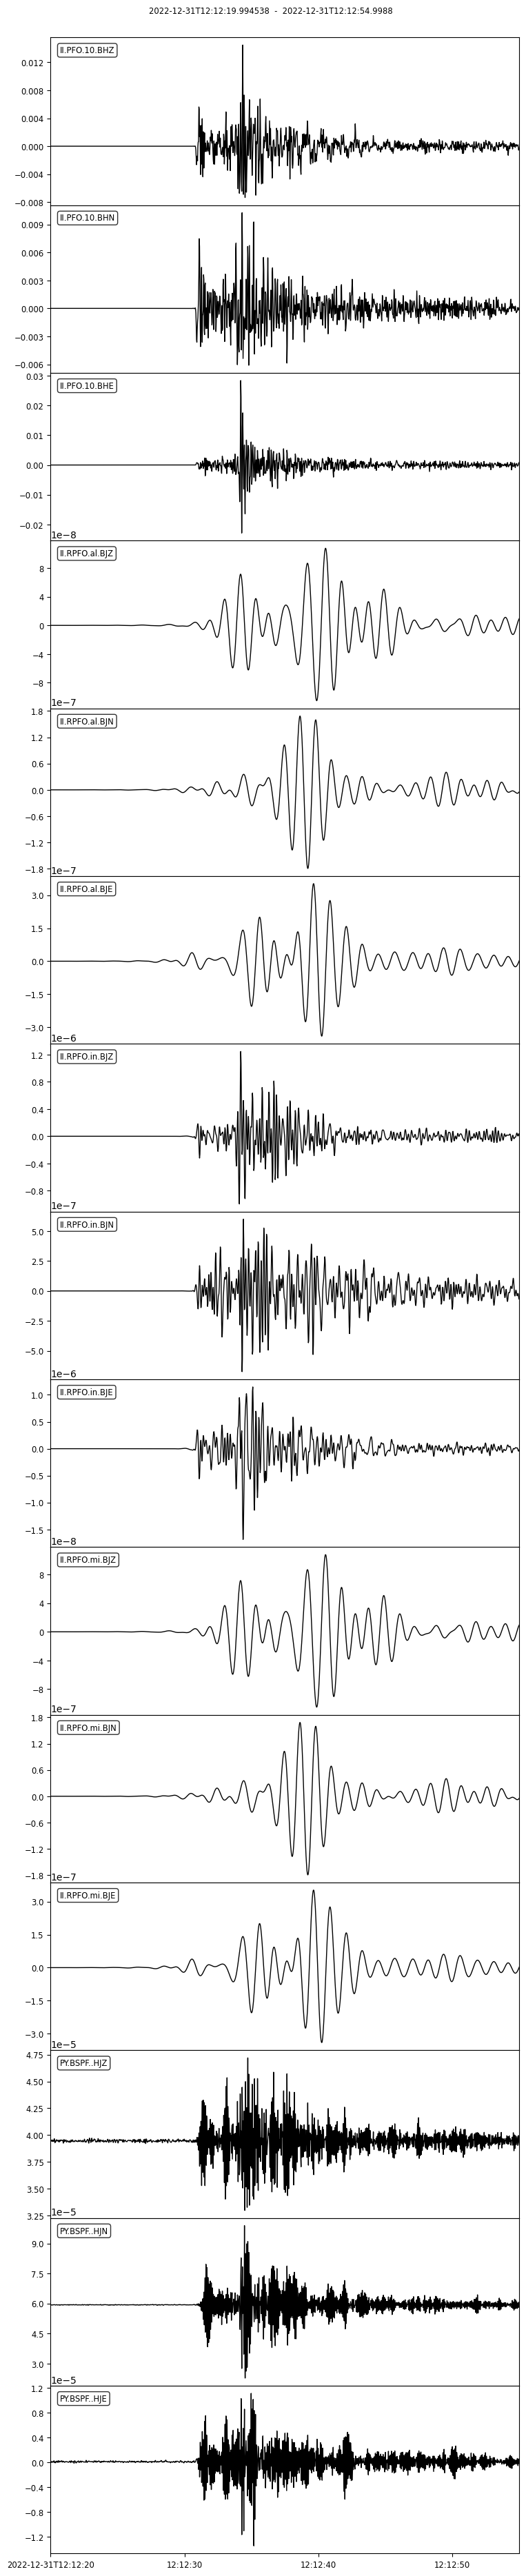

In [16]:
st = obs.read("./data/event42_6c.mseed")

tbeg = st[0].stats.starttime
tend = st[0].stats.endtime

st.plot(equal_scale=False);

In [19]:
acc = st.select(station="PFO*").copy()
rot = st.select(station="BSPF").copy()

## S-Transform

In [ ]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [ ]:
# fig = __makeplotStream_cwt(st, config);

## 6C Fingerprinting

In [20]:
from scipy.signal import hilbert, convolve

from twistpy.convenience import ricker
from twistpy.polarization import *

In [27]:
scaling_velocity = 1500

dt = rot[0].stats.delta

In [27]:
# !rm /home/brotzer/TwistPy/twistpy/SVC_models/nearsurface.pkl

svm = SupportVectorMachine(name="nearsurface")

svm.train(
    wave_types=["R", "L", "P", "SV", "SH", "Noise"],
    N=10000,
    scaling_velocity=scaling_velocity,
    vp=(100, 3000),
    vp_to_vs=(1.6, 2.2),
    vl=(100, 3000),
    vr=(100, 3000),
    phi=(0, 360),
    theta=(0, 90),
    xi=(-90, 90),
    free_surface=True,
    C=1,
    kernel="rbf",
    plot_confusion_matrix=False,
)

In [27]:
# rot.select(channel="*Z")[0].data *= -1

window = {"window_length_seconds": 10.0 * dt, "overlap": 0.5}

analysis = TimeDomainAnalysis6C(
    traN=acc.select(channel="*N")[0],
    traE=acc.select(channel="*E")[0],
    traZ=acc.select(channel="*Z")[0],
    rotN=rot.select(channel="*N")[0],
    rotE=rot.select(channel="*E")[0],
    rotZ=rot.select(channel="*Z")[0],
    window=window,
    scaling_velocity=scaling_velocity,
    timeaxis="rel",
)

analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

rm: cannot remove '/home/brotzer/TwistPy/twistpy/SVC_models/nearsurface.pkl': No such file or directory
A trained model already exists with this name and is saved at '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/nearsurface.pkl'
Nothing will be done! Please delete the file above if you want to re-train this model.
Computing covariance matrices...
Covariance matrices computed!
Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Wave types have been classified!


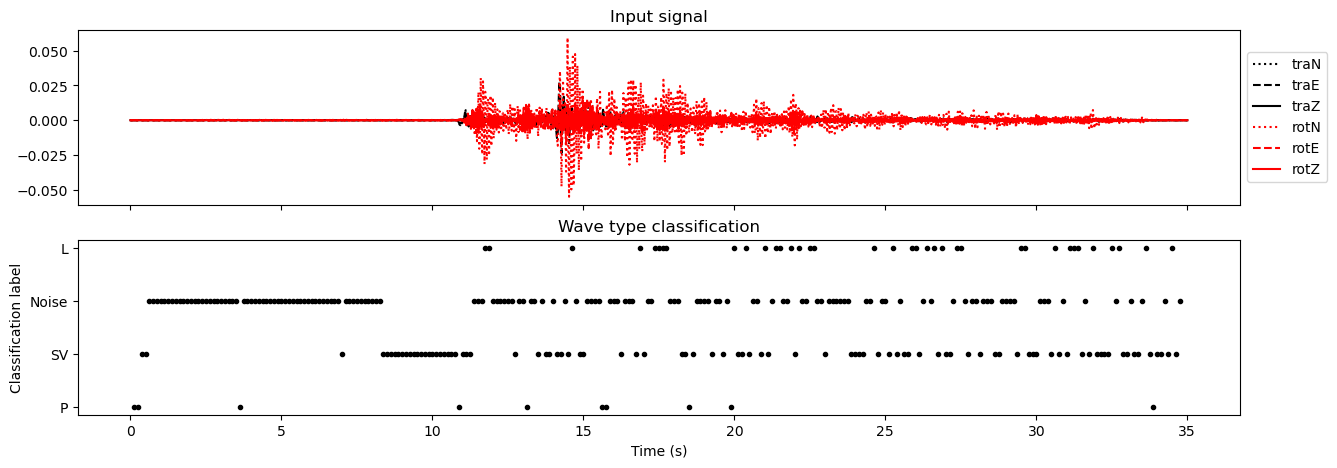

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, acc.select(channel="*Z")[0].data, "k", label="traZ")

ax1.plot(t, rot.select(channel="*N")[0].data*scaling_velocity, "r:", label="rotN")
ax1.plot(t, rot.select(channel="*E")[0].data*scaling_velocity, "r--", label="rotE")
ax1.plot(t, rot.select(channel="*Z")[0].data*scaling_velocity, "r", label="rotZ")

ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_title("Input signal")

ax2.plot(t_windows, classification, "k.")
ax2.set_title("Wave type classification")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Classification label")

plt.show();

In [ ]:
window = {"number_of_periods": 1, "frequency_extent": 2}

analysis_tf = TimeFrequencyAnalysis6C(
                                        traN=acc.select(channel="*N")[0],
                                        traE=acc.select(channel="*E")[0],
                                        traZ=acc.select(channel="*Z")[0],
                                        rotN=rot.select(channel="*N")[0],
                                        rotE=rot.select(channel="*E")[0],
                                        rotZ=rot.select(channel="*Z")[0],
                                        window=window,
                                        timeaxis="rel",
)

analysis_tf.classify(svm=svm, eigenvector_to_classify=0)

classification_tf = analysis_tf.classification["0"]


Computing covariance matrices...
Covariance matrices computed!
Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, acc.select(channel="*Z")[0].data, "k", label="traZ")
ax1.plot(t, rot.select(channel="*N")[0].data*scaling_velocity, "r:", label="rotN")
ax1.plot(t, rot.select(channel="*E")[0].data*scaling_velocity, "r--", label="rotE")
ax1.plot(t, rot.select(channel="*Z")[0].data*scaling_velocity, "r", label="rotZ")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_title("Input signal")

pos = ax2.get_position()
pos0 = ax1.get_position()
ax1.set_position([pos0.x0, pos0.y0, pos.width, pos.height])


ax2.set_title("Wave type classification")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Classification label")
analysis_tf.plot_classification(ax2)

plt.show();